In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

Pure sine wave PLAY!

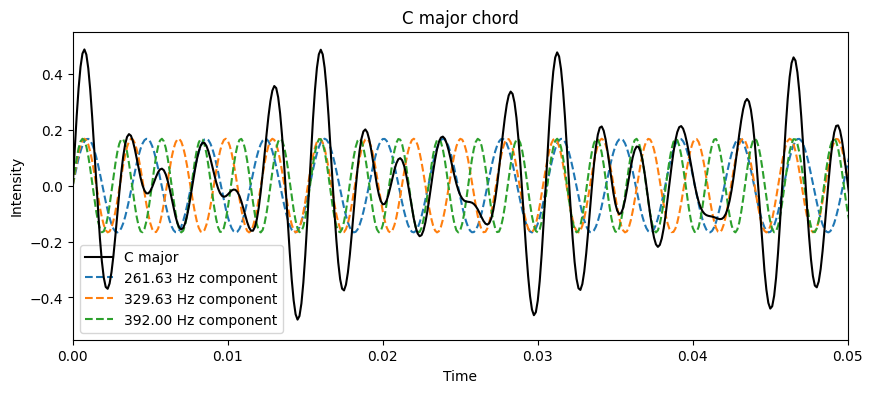

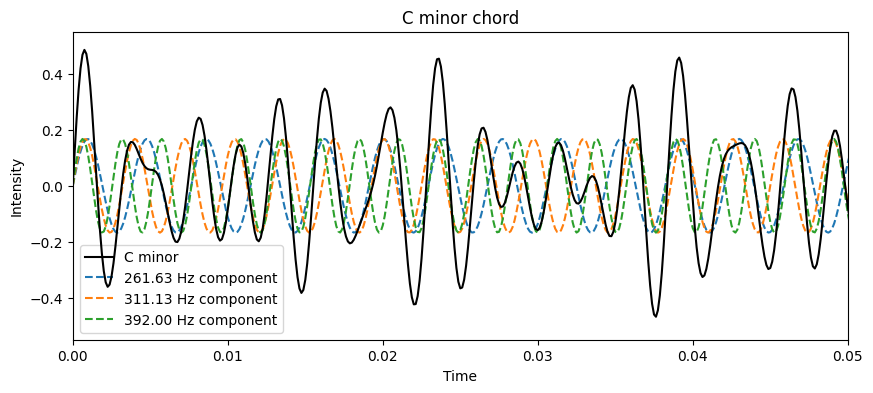

In [15]:
# Step up k-tones
def noteFromA4(k):
    return 440 * 2**(k/12)

def playAndPlot(lst, chordname):
    # Parameters
    fs = 8000       # Sampling rate (Hz)
    duration = 1.0  # Seconds of play

    # Generate sine wave
    freqs = [noteFromA4(step) for step in lst]
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    sines = [np.sin(2*np.pi*t * f) for f in freqs]

    chord = np.sum(sines, axis=0)
    suppress = 1 / (2 * np.max(chord)) # Max at 0.5 to avoid clipping
    chord = chord * suppress
    
    # Generate graph
    plt.figure(figsize=(10,4))
    plt.plot(t, chord, color='black', label=chordname, zorder=10)
    for f, sig in zip(freqs, sines):
        plt.plot(t, sig * suppress, label=f'{f:.2f} Hz component', linestyle='--', zorder=0)
    plt.title(f'{chordname} chord')
    plt.xlabel('Time'); plt.ylabel('Intensity')
    plt.xlim(0, 0.05)
    plt.legend()
    plt.show()
    
    # Play sound
    sd.play(chord, fs)
    sd.wait()

C_maj = [[-9, -5, -2], 'C major']
C_min = [[-9, -6, -2], 'C minor']

playAndPlot(*C_maj)
playAndPlot(*C_min)

String-like wave PLAY!

In [3]:
# String instrument functions
def karplus_strong(freq=440, duration=1, sample_rate=44100, decay=0.99):
    N = int(sample_rate / freq)  # delay line length
    # Initialize buffer with white noise
    buffer = np.random.rand(N) * 2 - 1
    output = []

    for _ in range(int(sample_rate * duration)):
        avg = decay * 0.5 * (buffer[0] + buffer[1])
        output.append(buffer[0])
        buffer = np.append(buffer[1:], avg)

    return np.array(output)

def chord(intervals):
    chord = np.sum([karplus_strong(freq=f, duration=1) for f in [freq(i) for i in intervals]], axis=0)
    chord /= np.max(chord)
    return chord

freq = lambda k: 440 * 2**(k / 12)
freqs = lambda k: 440 * 2**(np.arange(0, k) / 12)

# Play!
note = [karplus_strong(freq=f, duration=1) for f in freqs(5)]
A_major = chord([0, 4, 7])
A_minor = chord([0, 3, 7])

fs = 44100
for f, n in zip(freqs(5), note):
    sd.play(n, fs)
    print(f'{f:.2f} Hz played!')
    sd.wait()

sd.play(A_major, fs)
print(f'A Major chord played!')
sd.wait()

sd.play(A_minor, fs)
print(f'A Minor chord played!')
sd.wait()    

440.00 Hz played!
466.16 Hz played!
493.88 Hz played!
523.25 Hz played!
554.37 Hz played!
A Major chord played!
A Minor chord played!


String-like wave + ECHO PLAY!

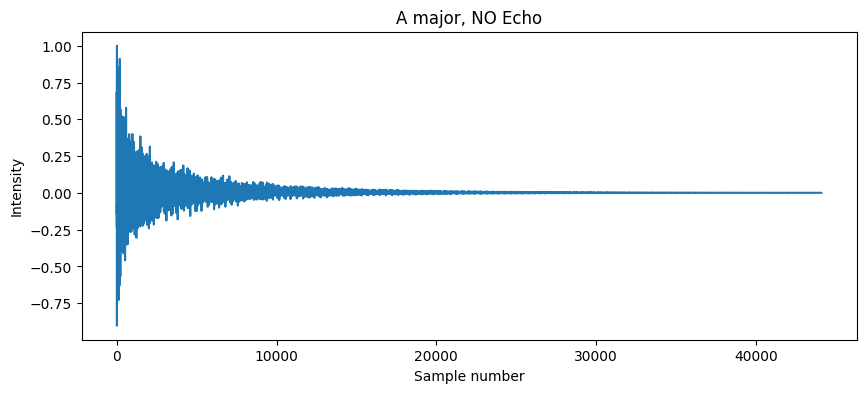

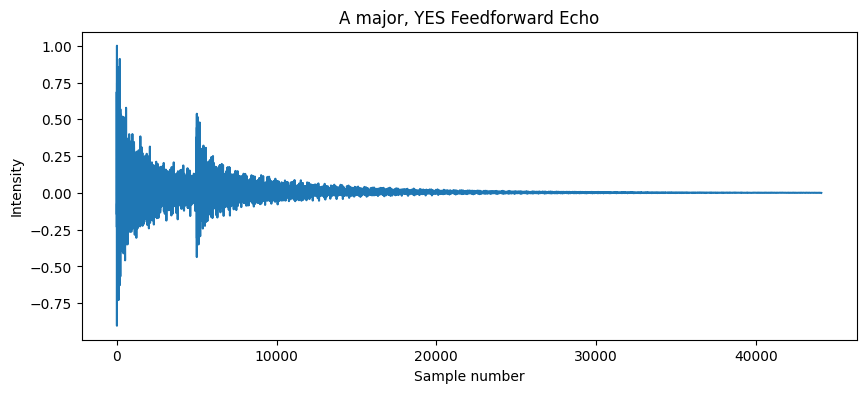

A Minor (Feedforward Echoed) played!


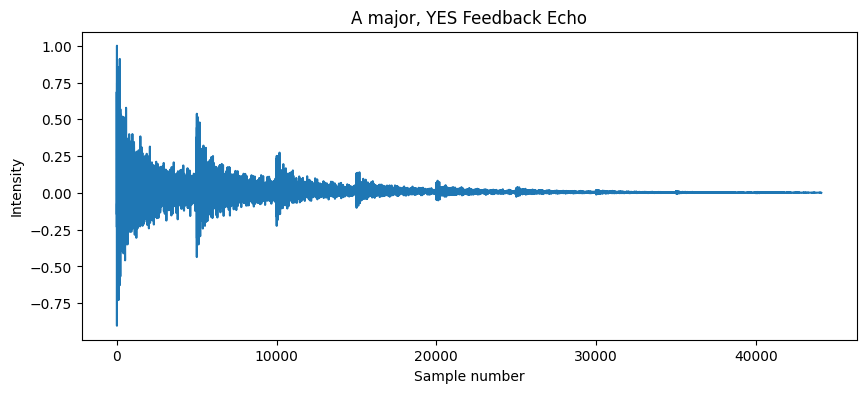

A Minor (Feedback Echoed) played!


In [63]:
# No echo
n = len(A_major)
plt.figure(figsize=(10,4))
plt.plot(range(n), A_major)
plt.xlabel('Sample number'); plt.ylabel('Intensity')
plt.title('A major, NO Echo')
plt.show()

# Feedforward echo
# Time to add echo
echo_intensity = 0.5
delay = 5000
Amaj_echo = np.zeros_like(A_major)

for k in range(n):
    Amaj_echo[k] = echo_intensity * A_major[k - delay] if (k - delay) >= 0 else 0
    Amaj_output = A_major + Amaj_echo

plt.figure(figsize=(10,4))
plt.plot(range(n), Amaj_output)
plt.xlabel('Sample number'); plt.ylabel('Intensity')
plt.title('A major, YES Feedforward Echo')
plt.show()

sd.play(Amaj_output, fs)
print(f'A Minor (Feedforward Echoed) played!')
sd.wait()

# Feedback echo
Amaj_output2 = np.copy(A_major)
for k in range(n):
    Amaj_output2[k] += echo_intensity * Amaj_output2[k - delay] if (k - delay) >= 0 else 0

plt.figure(figsize=(10,4))
plt.plot(range(n), Amaj_output2)
plt.xlabel('Sample number'); plt.ylabel('Intensity')
plt.title('A major, YES Feedback Echo')
plt.show()

sd.play(Amaj_output2, fs)
print(f'A Minor (Feedback Echoed) played!')
sd.wait()

Pure sine wave + VIBRATO play!

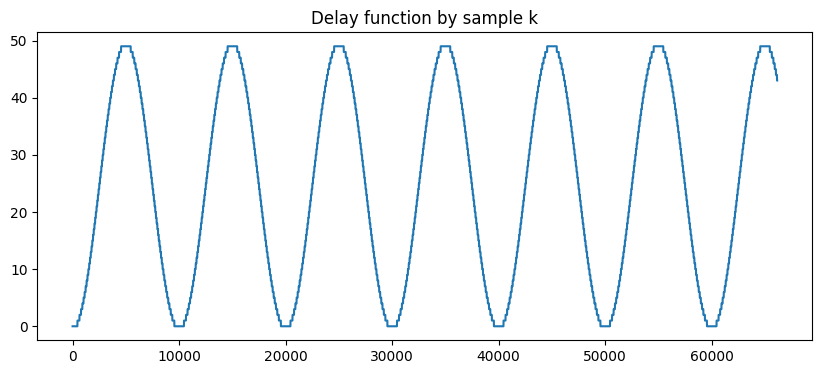

C major + VIBRATO played!


In [72]:
# Parameters
fs = 44100      # Sampling rate (Hz)
duration = 1.5  # Seconds of play

# Generate A major sine wave PLUS VIBRATO
freqs = [noteFromA4(step) for step in [0, 4, 7]]
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
sines = [np.sin(2*np.pi*t * f) for f in freqs]

chord = np.sum(sines, axis=0)
suppress = 1 / (2 * np.max(chord)) # Max at 0.5 to avoid clipping
chord = chord * suppress

chord_vib = np.zeros_like(chord)
n = len(chord)
max_d = 50
vib_d = lambda k: np.int32(max_d/2 * (1 - np.cos(2*np.pi * k * (fs/(1 + 1e-4))/fs)))
for k in range(n):
    chord_vib[k] = chord[k - vib_d(k)] if (k - vib_d(k)) >= 0 and (k - vib_d(k)) < n else 0

plt.figure(figsize=(10,4))
k = np.arange(n)
plt.plot(k, vib_d(k))
plt.title('Delay function by sample k')
plt.show()

sd.play(chord_vib, fs)
print(f'C major + VIBRATO played!')
sd.wait()

Guitar + FLANGER play!

In [ ]:
fs = 44100      # Sampling rate (Hz)
duration = 1.5  # Seconds of play
echo_intensity = 0.5
delay = 5000
A_major = chord([0, 4, 7])
vib_d = lambda k: np.int32(max_d/2 * (1 - np.cos(2*np.pi * k * (fs/(1 + 1e-4))/fs)))

Amaj_echo = np.zeros_like(A_major)

for k in range(n):
    condition = (k - delay) >= 0 and (k - vib_d(k)) >= 0 and (k - vib_d(k)) < n 
    Amaj_echo[k] = echo_intensity * A_major[k - delay] if condition else 0
    Amaj_output = A_major + Amaj_echo